In [207]:
import numpy as np

from tqdm import tqdm
import progressbar

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.metrics.pairwise import manhattan_distances

import pandas as pd

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [107]:
data = pd.read_csv('tsp.csv', header=None).drop([0], axis=1)
data.columns = ['x', 'y']

In [108]:
class Hillclimbing(object):
    def __init__(self, max_iter=100, mutations_count=10, objects_to_mutate=10):
        self.max_iter=max_iter
        self.mutations_count=mutations_count
        self.objects_to_mutate=objects_to_mutate
    
    def fit(self, data):
        self.distance_ = manhattan_distances(data)
        self.city_order = list(range(self.distance_.shape[0]))
        self.cost = self.path_cost()
        
        for _ in range(self.max_iter):
            step_res = list()
            for _ in range(self.objects_to_mutate):
                current_order = list(self.city_order)
                for _ in range(self.mutations_count):
                    i = np.random.randint(0, self.distance_.shape[0])
                    j = np.random.randint(0, self.distance_.shape[0])
                    
                    self.swap_cities(current_order, i, j)
                
                current_cost = self.path_cost(current_order)
                step_res.append((self.cost - current_cost, current_cost, current_order))
            
            step_res = sorted(step_res, reverse=True)
            if step_res[0][0] > 0:
                self.cost, self.city_order = step_res[0][1], step_res[0][2]
        
    @staticmethod
    def swap_cities(cities, i, j):
        cities[i], cities[j] = cities[j], cities[i]
    
    def path_cost(self, cities=None):
        if cities is None:
            cities = self.city_order
            
        return np.sum([self.distance_[i, j] for (i, j) in zip(cities[:-1], cities[1:])])

In [111]:
hc = Hillclimbing(max_iter=10000)
hc.fit(data)

In [112]:
hc.path_cost()

19255.0

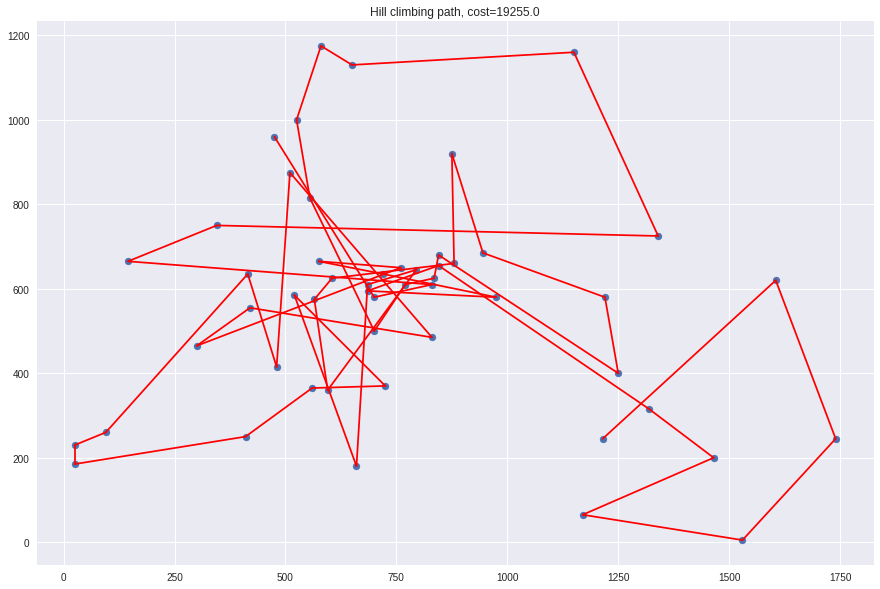

In [154]:
plt.figure(figsize=(15,10))
plt.scatter(data['x'], data['y'])
for p, n in zip(hc.city_order[:-1], hc.city_order[1:]):
    p_x, p_y = data.loc[p,]['x'], data.loc[p,]['y']
    n_x, n_y = data.loc[n,]['x'], data.loc[n,]['y']
    
    plt.plot([p_x, n_x], [p_y, n_y], color='red')
plt.title('Hill climbing path, cost={}'.format(hc.cost))

In [139]:
class Annealing(object):
    def __init__(self, max_iter=100, mutations_count=10, objects_to_mutate=10):
        self.max_iter=max_iter
        self.mutations_count=mutations_count
        self.objects_to_mutate=objects_to_mutate
    
    def fit(self, data):
        current_temp = self.tempreture
        self.distance_ = manhattan_distances(data)
        self.city_order = list(range(self.distance_.shape[0]))
        self.cost = self.path_cost()
        
        while current_temp > 1.:
            current_order = list(self.city_order)
            step_res = list()
            for _ in range(self.mutation_rate):
                i = np.random.randint(0, self.distance_.shape[0])
                j = np.random.randint(0, self.distance_.shape[0])

                self.swap_cities(current_order, i, j)
                
            current_cost = self.path_cost(current_order)
            if current_cost < self.cost:
                self.city_order = current_order
                self.cost = current_cost
            else:
                current_temp *= (1 - self.alpha)
        
    @staticmethod
    def swap_cities(cities, i, j):
        cities[i], cities[j] = cities[j], cities[i]
    
    def path_cost(self, cities=None):
        if cities is None:
            cities = self.city_order
            
        return np.sum([self.distance_[i, j] for (i, j) in zip(cities[:-1], cities[1:])])

In [150]:
ann = Annealing(alpha=0.00005)
ann.fit(data)

In [151]:
ann.path_cost()

20360.0

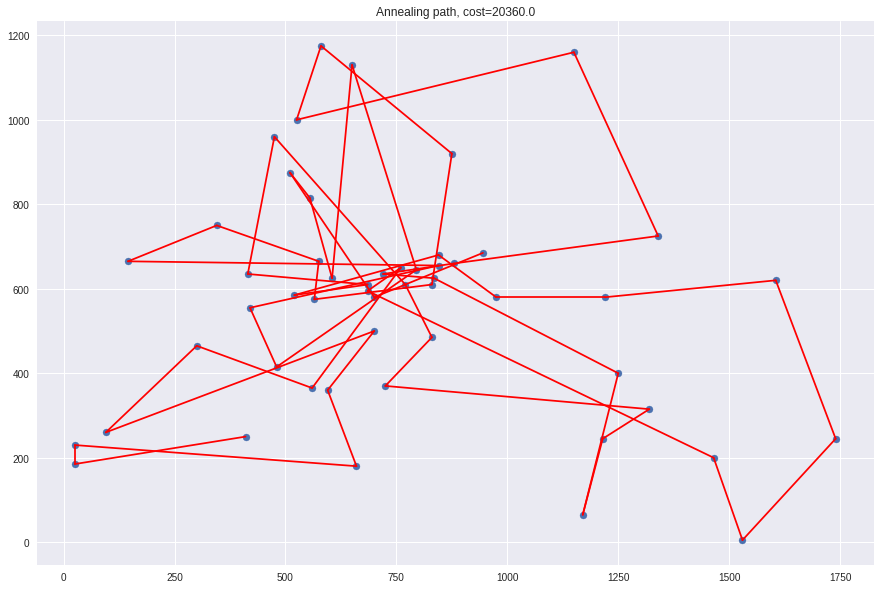

In [155]:
plt.figure(figsize=(15,10))
plt.scatter(data['x'], data['y'])
for p, n in zip(ann.city_order[:-1], ann.city_order[1:]):
    p_x, p_y = data.loc[p,]['x'], data.loc[p,]['y']
    n_x, n_y = data.loc[n,]['x'], data.loc[n,]['y']
    
    plt.plot([p_x, n_x], [p_y, n_y], color='red')
plt.title('Annealing path, cost={}'.format(ann.cost))

In [208]:
class Genetic(object):
    def __init__(self, max_iter=100, mutations_count=10, candidates=10, surv_rate=0.25):
        self.max_iter=max_iter
        self.candidates=candidates
        self.survaviors_count=int(candidates*surv_rate)
        self.mutations_count=mutations_count
    
    def fit(self, data):
        self.distance_ = manhattan_distances(data)
        
        survaviors = list()
        progress = progressbar.ProgressBar()
        for _ in progress(range(self.max_iter)):
            while len(survaviors) < self.candidates:
                survaviors.append(self.random_order())
                
            survaviors = sorted(survaviors, key = lambda s: self.path_cost(s))[:self.survaviors_count]
            for k in range(len(survaviors)):
                for _ in range(self.mutations_count):
                    i = np.random.randint(0, self.distance_.shape[0])
                    j = np.random.randint(0, self.distance_.shape[0])
                    self.swap_cities(survaviors[k], i, j)
                
        self.city_order = survaviors[0]
        self.cost = self.path_cost()
                
    def random_order(self):
        return list(np.random.permutation(self.distance_.shape[0]))
                
    @staticmethod
    def swap_cities(cities, i, j):
        cities[i], cities[j] = cities[j], cities[i]
    
    def path_cost(self, cities=None):
        if cities is None:
            cities = self.city_order
            
        return np.sum([self.distance_[i, j] for (i, j) in zip(cities[:-1], cities[1:])])

In [209]:
gen = Genetic(max_iter=100000, mutations_count=10, candidates=30)
gen.fit(data)

100% |########################################################################|


In [210]:
gen.cost

34235.0

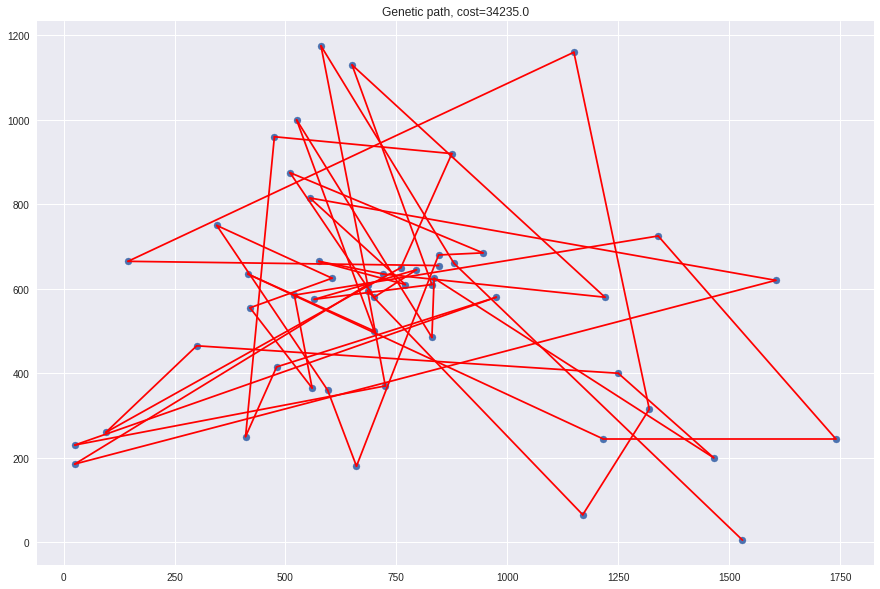

In [211]:
plt.figure(figsize=(15,10))
plt.scatter(data['x'], data['y'])
for p, n in zip(gen.city_order[:-1], gen.city_order[1:]):
    p_x, p_y = data.loc[p,]['x'], data.loc[p,]['y']
    n_x, n_y = data.loc[n,]['x'], data.loc[n,]['y']
    
    plt.plot([p_x, n_x], [p_y, n_y], color='red')
plt.title('Genetic path, cost={}'.format(gen.cost))